<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Vadere" data-toc-modified-id="Vadere-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Vadere</a></span></li><li><span><a href="#Experiment" data-toc-modified-id="Experiment-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Experiment</a></span></li></ul></div>

In [1]:
import numpy as np
import pandas as pd
import scipy.spatial as spatial
import matplotlib.pyplot as plt
import matplotlib.path as path
import matplotlib as mpl
import os
import sys
import vadereanalysistool
from tqdm import tqdm_notebook
from shapely.geometry import Polygon, MultiPolygon, Point

module_path = os.path.abspath(os.path.join('../python/python_src_preprocessing/src'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from utils.reader import get_all_trajectory_files, read_trajectory_file

%load_ext autoreload
%load_ext line_profiler
%autoreload 1
%aimport voronoi

In [14]:
%lprun?

# Vadere

In [2]:
project = vadereanalysistool.VadereProject('../../../VadereModelTests/TestCWL/')
scenarios = list(filter(lambda x: not x.startswith('__'), dir(project.named_output)))

loaded 12 out of 12 output directories. 


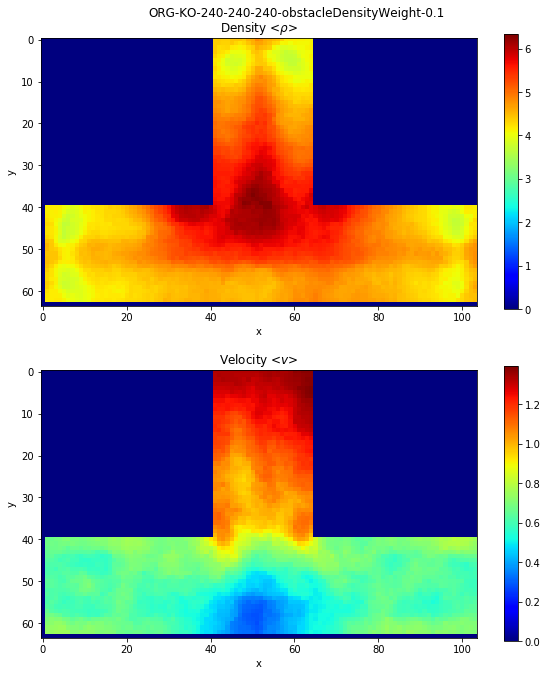

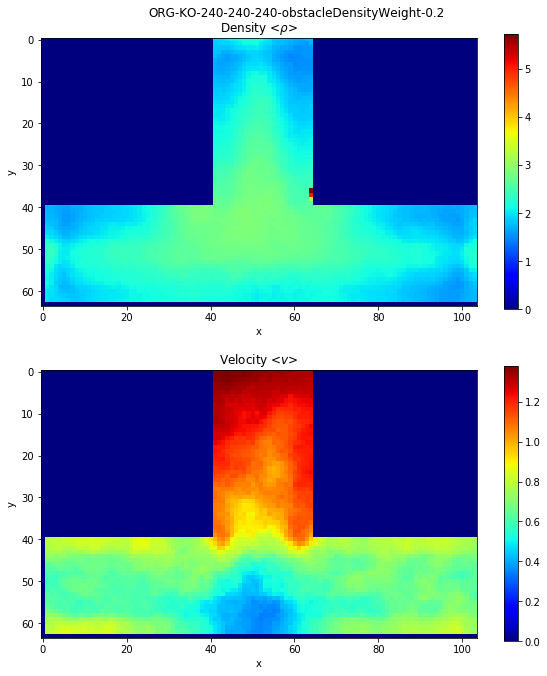

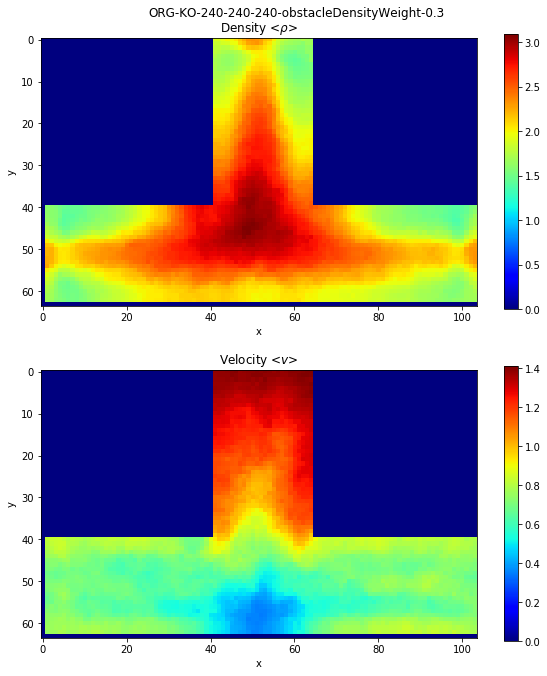

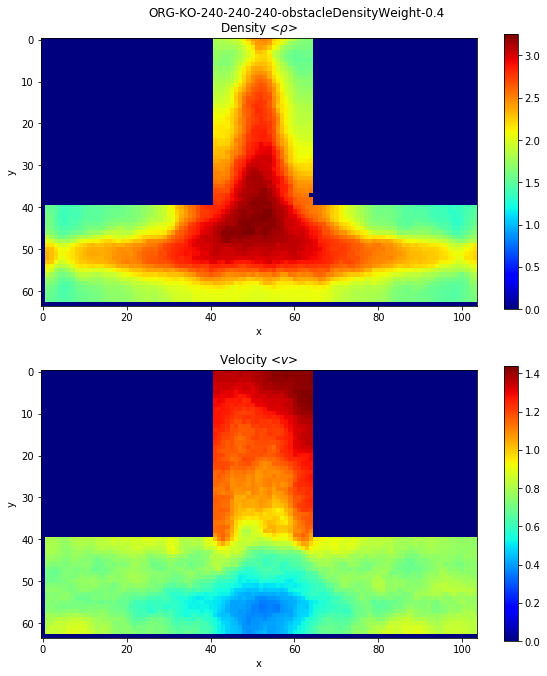

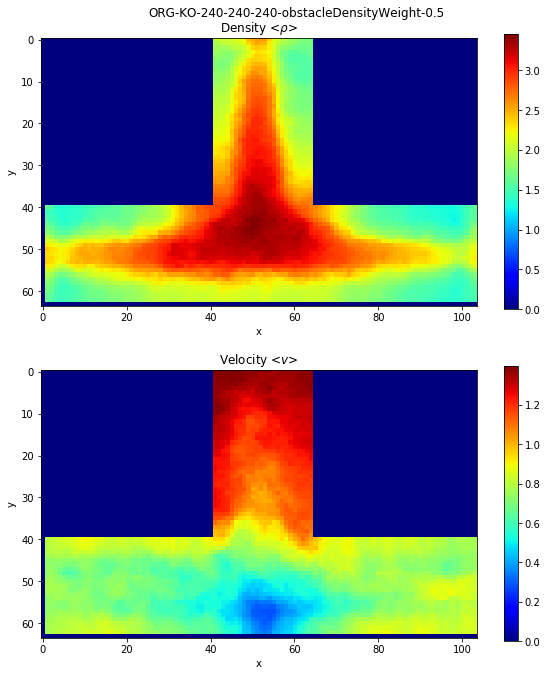

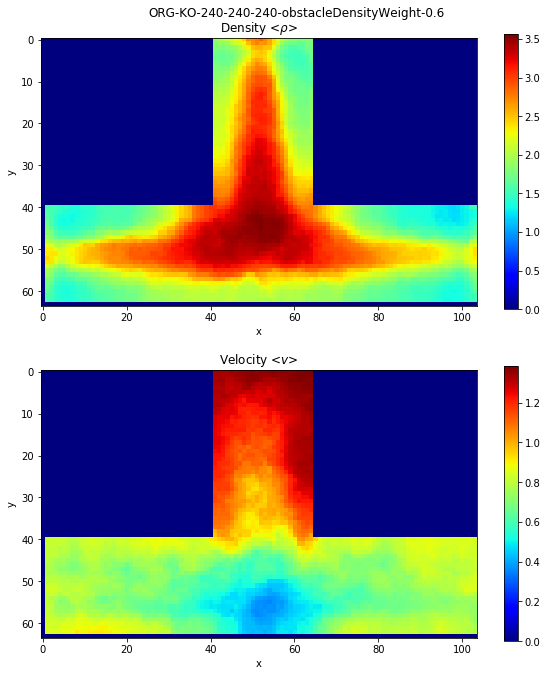

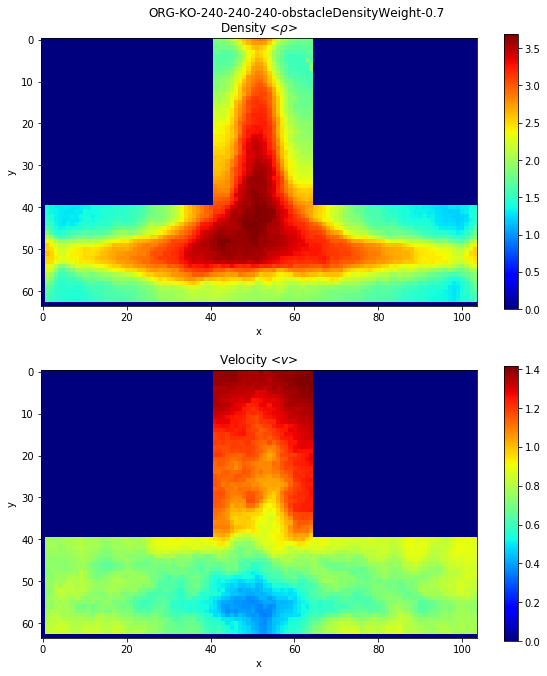

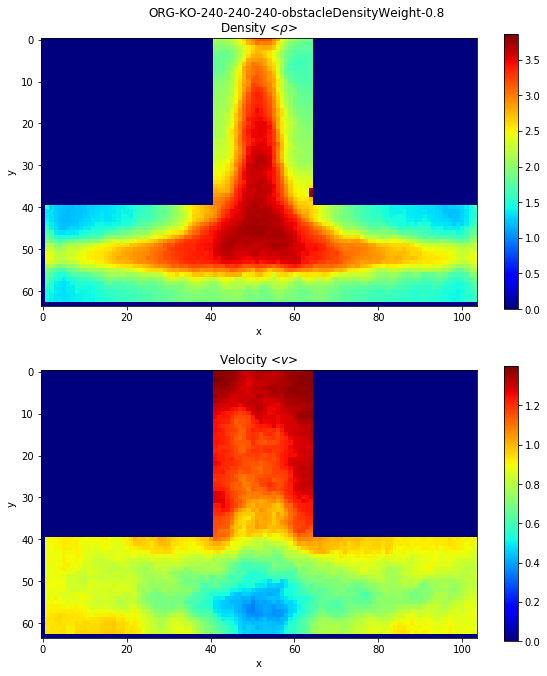

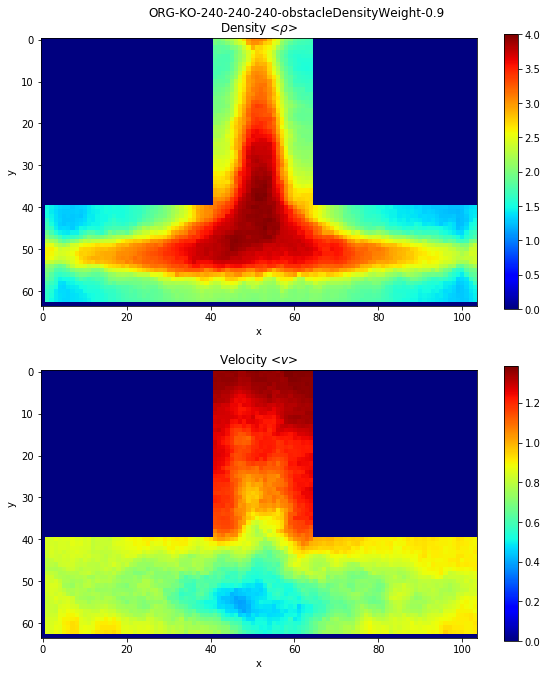

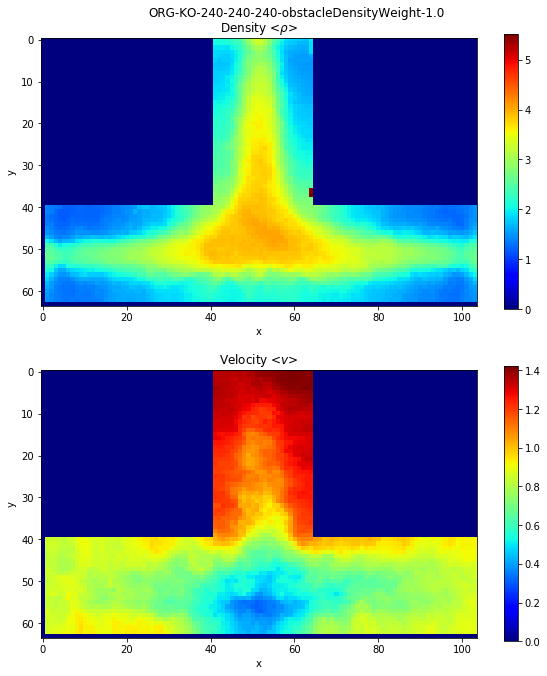

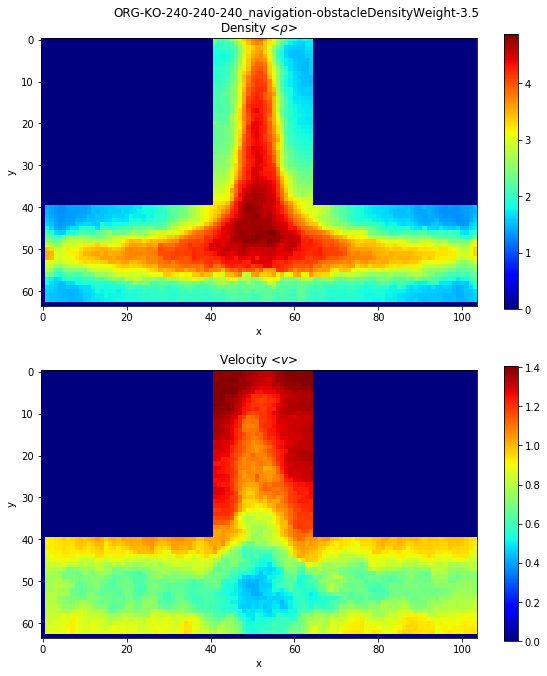

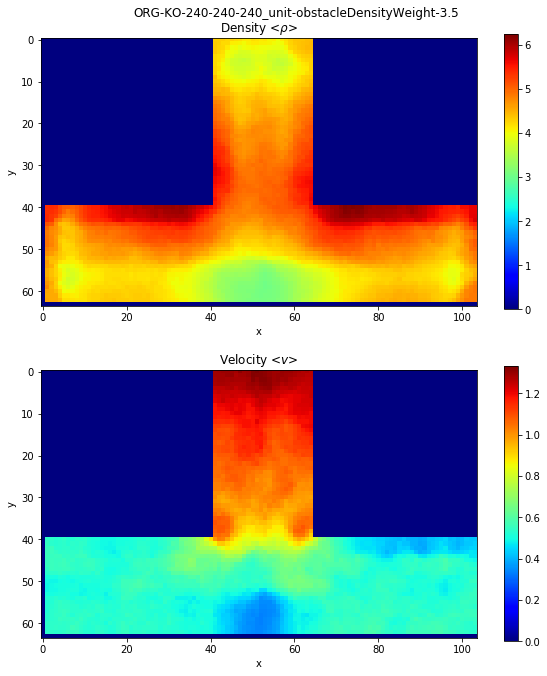

In [17]:
force = False
for scenario in scenarios:
    output = getattr(project.named_output, scenario)()
    name = "{0}-obstacleDensityWeight-{1}".format(
        output.scenario['name'],
        output.scenario['scenario']['attributesModel']['org.vadere.state.attributes.models.AttributesFloorField']['timeCostAttributes']['obstacleDensityWeight']
    )
    
    D, V = (None, None)
    
    if force or not (os.path.isfile(os.path.join(output.output_dir, 'density.npy')) and os.path.isfile(os.path.join(output.output_dir, 'density.npy'))):    
        df = output.named_files.df_postvis_trajectories()
        '''
        D, V = voronoi.run(
            df,
            dict({
                'area': [14.5, 1.3, 10.4, 6.4],
                'boundary': Polygon([[14.5, 1.3], [14.5, 3.7], [18.5, 3.7], [18.5, 7.7], [20.9, 7.7], [20.9, 3.7], [24.9, 3.7], [24.9, 1.3]]),
                'skip': 5
            }), 
            nprocesses=3
        )
        '''
        
        context = dict({
            'area': [14.5, 1.3, 10.4, 6.4],
            'boundary': Polygon([[14.5, 1.3], [14.5, 3.7], [18.5, 3.7], [18.5, 7.7], [20.9, 7.7], [20.9, 3.7], [24.9, 3.7], [24.9, 1.3]]),
            #'boundary': Polygon([[14.5, 1.3], [14.5, 7.7], [24.9, 7.7], [24.9, 1.3]]),
            'skip': 5,
            'name': name
        })
        
        # %lprun -f voronoi.run -f voronoi.process_timestep voronoi.run(df, context, nprocesses=1)
        D, V = voronoi.run(df, context, nprocesses=6)
        
        np.save(os.path.join(output.output_dir, 'density.npy'), D)
        np.save(os.path.join(output.output_dir, 'velocity.npy'), V)
    
    if D is None:
        D = np.load(os.path.join(output.output_dir, 'density.npy'))
        V = np.load(os.path.join(output.output_dir, 'velocity.npy'))
    
    # print(np.sort(D.ravel(), kind='mergesort')[::-1])
    D[D > 7] = 0 # cut density artifacts

    fig, pl = plt.subplots(nrows=2, ncols=1, figsize=(800 / 96, 900 / 96))
    
    
    img = pl[0].imshow(D, cmap='jet')
    pl[0].set_title("Density <$\\rho$>")
    pl[0].set_xlabel('x')
    pl[0].set_ylabel('y')
    fig.colorbar(img, ax=pl[0])

    img = pl[1].imshow(V, cmap='jet')
    pl[1].set_title("Velocity <$v$>")
    pl[1].set_xlabel('x')
    pl[1].set_ylabel('y')
    fig.colorbar(img, ax=pl[1])
    fig.tight_layout()
    fig.suptitle(name, y=1)
    fig.savefig(name + '.pdf')
    

# Experiment

In [27]:
def load_experiment(folder, key):
    files = list(filter(lambda file: key in file, os.listdir(folder)))
    
    if len(files) == 0:
        return None
    
    data = pd.read_csv(
        os.path.join(folder, files[0]), 
        sep=' ', 
        names=['pedestrianId', 'timeStep', 'x', 'y', 'e'], 
        index_col=False, 
        header=None, 
        skiprows=0)
        
    data['x'] = data['x'] / 100
    data['y'] = data['y'] / 100
    
    print('loaded', files[0])
    
    return files[0], data
    
def load_multiple(path, folders, key):
    frames = []
    for folder in folders:
        frames.append(load_experiment(join(path, folder), key))
            
    return frames

In [19]:
input_path = 'KO/'
output_path = 'juelich/output_test/'
experiments = [
    # 'ko-240-050-240',
    # 'ko-240-060-240',
    # 'ko-240-080-240',
    # 'ko-240-100-240',
    # 'ko-240-120-240',
    # 'ko-240-150-240',
    'ko-240-240-240',
    # 'ko-300-050-300',
    # 'ko-300-080-300',
    # 'ko-300-120-300',
    # 'ko-300-150-300'
]

loaded ko-240-240-240_combined_MB.txt


original-ko-240-240-240_combined_MB.txt: 100%|█████████████████████████████████████| 1414/1414 [04:45<00:00,  4.95it/s]


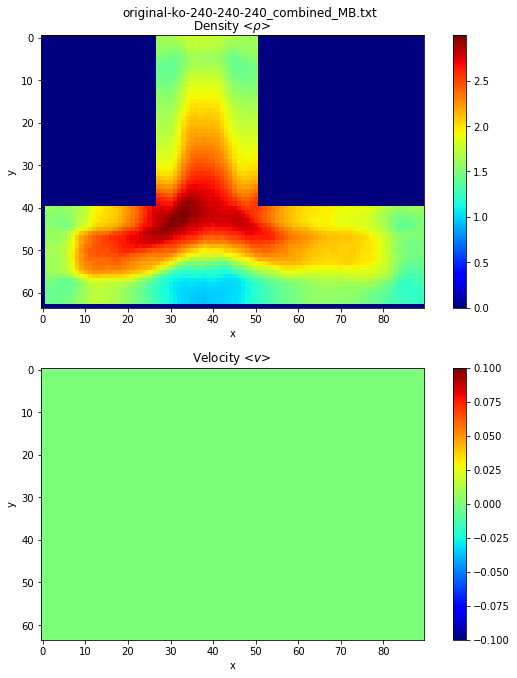

In [31]:
force = True
for experiment in experiments:
    
    D, V = (None, None)
    
    if force or not (os.path.isfile(os.path.join(input_path, experiment, 'density.npy')) and os.path.isfile(os.path.join(input_path, experiment, 'density.npy'))):    
        filename, frame = load_experiment(os.path.join(input_path, experiment), 'combined')
        name = 'original-{0}'.format(filename)
        
        context = dict({
            'area': [-5, -2.4, 9, 6.4], 
            'boundary': Polygon([[-5.0, -2.4], [-5.0, 0.0], [-2.4, 0.0], [-2.4, 4.0], [0.0, 4.0], [0.0, 0.0], [4.0, 0.0], [4.0, -2.4]]),
            'skip': 1,
            'name': name
        })
        
        D, V = voronoi.run(frame, context, nprocesses=3)
        
        np.save(os.path.join(input_path, experiment, 'density.npy'), D)
        np.save(os.path.join(input_path, experiment, 'velocity.npy'), V)
    
    if D is None:
        D = np.load(os.path.join(input_path, experiment, 'density.npy'))
        V = np.load(os.path.join(input_path, experiment, 'velocity.npy'))
    
    
    fig, pl = plt.subplots(nrows=2, ncols=1, figsize=(800 / 96, 900 / 96))
    
    
    img = pl[0].imshow(D, cmap='jet')
    pl[0].set_title("Density <$\\rho$>")
    pl[0].set_xlabel('x')
    pl[0].set_ylabel('y')
    fig.colorbar(img, ax=pl[0])

    img = pl[1].imshow(V, cmap='jet')
    pl[1].set_title("Velocity <$v$>")
    pl[1].set_xlabel('x')
    pl[1].set_ylabel('y')
    fig.colorbar(img, ax=pl[1])
    fig.tight_layout()
    fig.suptitle(name, y=1)
    fig.savefig(name + '.pdf')
    